In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette='muted')
from pathlib import Path

In [3]:
path = Path('data')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data')

### Prepare the data

In [4]:
# Download data from https://www.kaggle.com/mlg-ulb/creditcardfraud

In [5]:
df = pd.read_csv(path/f"creditcard.csv")
print(df.shape)

(284807, 31)


In [6]:
df.isnull().values.any()

False

In [7]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [9]:
df.groupby(df.Class).Amount.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


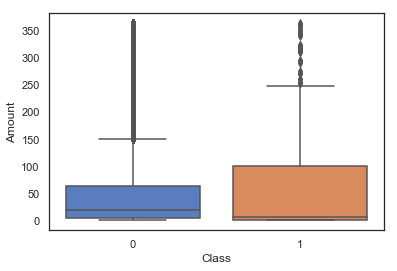

In [10]:
sns.boxplot(x='Class', y='Amount', data=df[df.Amount < df.Amount.quantile(0.95)])

In [11]:
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)

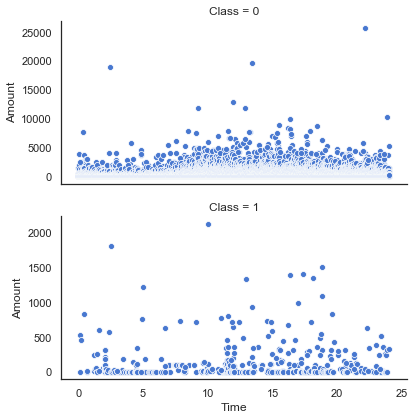

In [12]:
g = sns.FacetGrid(df, sharey=False, height=3, aspect=2, row="Class")
g = g.map(sns.scatterplot, 'Time', "Amount");

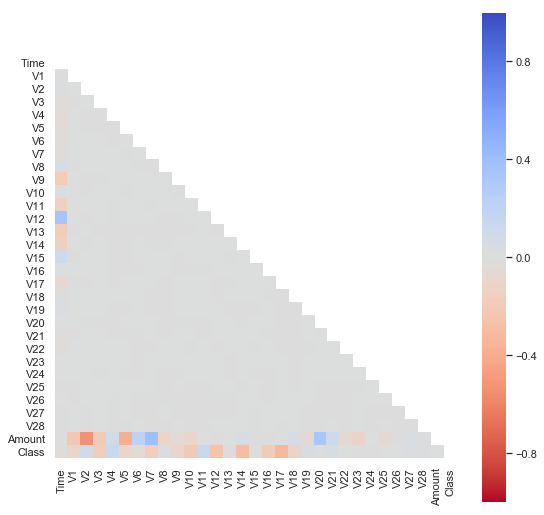

In [13]:
def plot_corrmap(df):
    corr_all = df.corr()
    mask = np.zeros_like(corr_all, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(corr_all, mask=mask, square=True, ax=ax, vmin=-1, vmax=1, cmap="coolwarm_r")      
    plt.show()

plot_corrmap(df)

In [14]:
fraud = df[df.Class == 1]
non_fraud = df[df.Class == 0]

In [15]:
# Create balanced dataset for finding best classifier
df_b = non_fraud.sample(len(fraud)).append(fraud).reset_index(drop=True)
y_b = df_b.Class.values
X_b = df_b.drop('Class', axis=1).values

X_b.shape, y_b.shape

((984, 30), (984,))

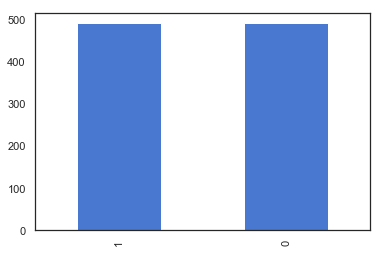

In [16]:
pd.Series(y_b).value_counts().plot.bar();

In [17]:
# Oversample training data with SMOTE
from imblearn.over_sampling import SMOTE

df_smote = non_fraud.sample(len(fraud) * 5).append(fraud).reset_index(drop=True)

# Synthesize elements for the minority class by computing the k-nearest neighbors
smote = SMOTE(ratio='minority')
X, y = smote.fit_sample(df_smote.drop('Class', axis=1).values, df_smote.Class.values)

X.shape, y.shape

((4920, 30), (4920,))

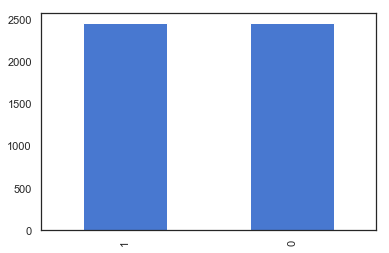

In [18]:
pd.Series(y).value_counts().plot.bar();

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.4)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((2952, 30), (1968, 30), (2952,), (1968,))

### Compare classifiers

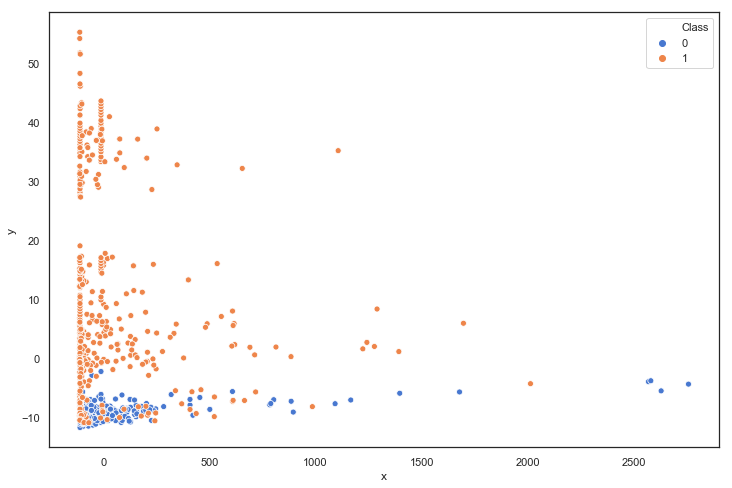

In [20]:
from sklearn.decomposition import PCA

def plot_pca(X, y):
    pca = PCA(n_components=2)
    X_t = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(X_t, columns=['x', 'y'])
    pca_df['Class'] = y

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='x', y='y', hue='Class', data=pca_df)
    plt.show()
    
plot_pca(X_b, y_b)

LogRes: 0.954628 (0.013234)
kNN: 0.926216 (0.020489)
LinSVM: 0.968917 (0.013826)
GaussianProcess: 0.965509 (0.008536)
DecisionTree: 0.901974 (0.025299)
RandomForest: 0.952837 (0.006478)
MLP: 0.959337 (0.017421)
AdaBoost: 0.958073 (0.016453)
NaiveBayes: 0.947991 (0.017111)
QDA: 0.952570 (0.020658)


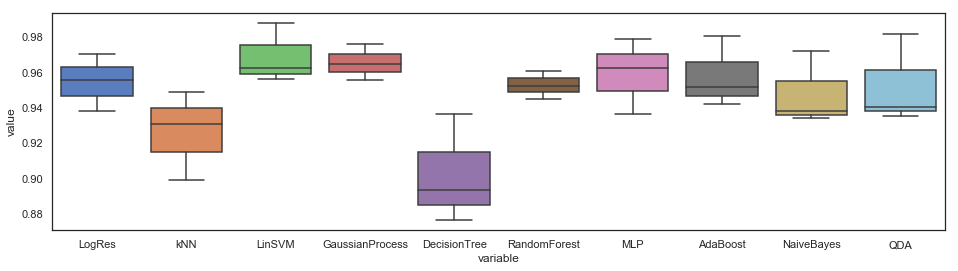

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def compare_classifiers(X, y, scoring):
    X = StandardScaler().fit_transform(X)
    classifiers = {
        'LogRes': LogisticRegression(solver='liblinear'),
        "kNN": KNeighborsClassifier(3),
        "LinSVM": SVC(kernel="linear", C=0.025),
        "GaussianProcess": GaussianProcessClassifier(1.0 * RBF(1.0)),
        "DecisionTree": DecisionTreeClassifier(max_depth=5),
        "RandomForest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        "MLP": MLPClassifier(alpha=1, max_iter=500),
        "AdaBoost": AdaBoostClassifier(),
        "NaiveBayes": GaussianNB(),
        "QDA": QuadraticDiscriminantAnalysis()
    }

    results_df = pd.DataFrame()
    for name, model in classifiers.items():
        skf = StratifiedKFold(n_splits=3)
        cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=False)
        scores = cv_results['test_score']
        results_df[name] = scores
        msg = "%s: %f (%f)" % (name, scores.mean(), scores.std())
        print(msg)

    melted_df = pd.melt(results_df, id_vars=[], value_vars=results_df.columns)
    plt.figure(figsize=(16, 4))
    sns.boxplot(x='variable', y='value', data=melted_df)
    plt.show()
    
compare_classifiers(X_b, y_b, 'roc_auc')

In [22]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', GaussianProcessClassifier(1.0 * RBF(1.0))),
])

In [23]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), max_iter_predict=100,
             multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False))])

In [127]:
y_proba_clf = pipe.predict_proba(X_valid)[:, 1]

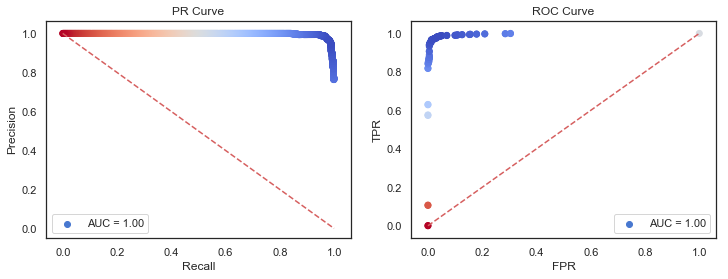

In [25]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

def plot_curves(y_true, y_proba):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    p, r, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    ax1.scatter(r, p, label='AUC = %0.2f'% pr_auc, c=(p+2*r)/2, cmap=plt.cm.coolwarm_r)
    ax1.plot([0, 1], [1, 0], 'r--')
    ax1.legend()
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')
    
    # Use ROC AUC if classes are not highly imbalanced
    # The AUC gives you the probability that your classifier assigns a higher score to the positive example
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    ax2.scatter(fpr, tpr, label='AUC = %0.2f'% roc_auc, c=(2*tpr+1-fpr)/2, cmap=plt.cm.coolwarm_r)
    ax2.plot([0, 1], [0, 1], 'r--')
    ax2.legend()
    ax2.set_xlabel('FPR')
    ax2.set_ylabel('TPR')
    ax2.set_title('ROC Curve')
    
    plt.show()
    
plot_curves(y_valid, y_proba_clf)

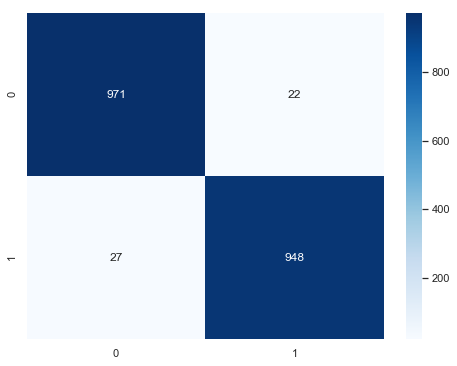

In [26]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, fmt="d")
    plt.show()

plot_confusion_matrix(y_valid, y_proba_clf > .5)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_proba_clf > .5))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       993
           1       0.98      0.97      0.97       975

   micro avg       0.98      0.98      0.98      1968
   macro avg       0.98      0.98      0.98      1968
weighted avg       0.98      0.98      0.98      1968



### Binary classifier

In [28]:
from torch import nn

class BCModel(nn.Module):
    def __init__(self, in_size, num_units, dropout):
        super(BCModel, self).__init__()
        self.fc1 = nn.Linear(in_size, num_units)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(num_units, 1)
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

In [29]:
# Requires data type Float and an extra dimension for targets
X_b_bc = StandardScaler().fit_transform(X_b).astype(np.float32)
y_b_bc = np.expand_dims(y_b, 1).astype(np.float32)

In [30]:
# Wrap a PyTorch module to make a sklearn-compatible neural network
from skorch import NeuralNet
from torch.optim import Adam

# Make recall weight more
pos_weight = torch.FloatTensor([2.])

bc_net = NeuralNet(
    module=BCModel,
    module__in_size=X_b_bc.shape[1],
    optimizer=Adam,
    criterion=torch.nn.BCEWithLogitsLoss,
    criterion__pos_weight=pos_weight,
    max_epochs=20,
    lr=1e-2,
    verbose=0
)

In [31]:
%%time
# Perform a grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, accuracy_score

params = {
    'module__num_units': range(10, 110, 10),
    'module__dropout': [0., 0.1, 0.2, 0.3, 0.4, 0.5]
}

def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

def nn_accuracy(y_valid, y_pred):
    return accuracy_score(y_valid.squeeze(), sigmoid(y_pred.squeeze()) > .5)
def nn_precision(y_valid, y_pred):
    return precision_score(y_valid.squeeze(), sigmoid(y_pred.squeeze()) > .5)
def nn_recall(y_valid, y_pred):
    return recall_score(y_valid.squeeze(), sigmoid(y_pred.squeeze()) > .5)
def nn_roc_auc(y_valid, y_pred):
    return roc_auc_score(y_valid.squeeze(), sigmoid(y_pred.squeeze()))

scoring = {
    'accuracy': make_scorer(nn_accuracy),
    'precision': make_scorer(nn_precision), 
    'recall': make_scorer(nn_recall), 
    'roc_auc': make_scorer(nn_roc_auc)
}
skf = StratifiedKFold(n_splits=3, random_state=42)
gs = GridSearchCV(bc_net, params, refit=False, cv=skf, scoring=scoring, return_train_score=False, verbose=0)

gs.fit(X_b_bc, y_b_bc)

CPU times: user 3min 27s, sys: 1.23 s, total: 3min 28s
Wall time: 1min 13s


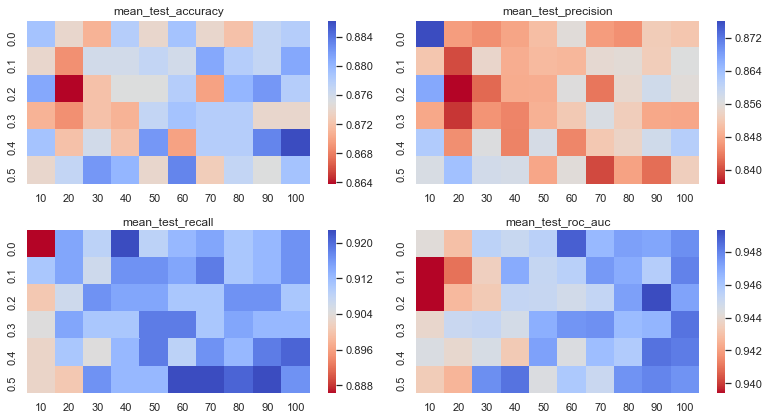

In [32]:
# Visualize best parameters

def plot_grid_results():
    fig = plt.figure(figsize=(11, 6))
    
    for i, param in enumerate(['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc']):
        ax = fig.add_subplot(221 + i)
        grid_df = pd.DataFrame(0, columns=params['module__num_units'], index=params['module__dropout'])
        for i, (p1, p2) in enumerate([d.values() for d in gs.cv_results_['params']]):
            grid_df.loc[p1, p2] = gs.cv_results_[param][i]
        sns.heatmap(grid_df, cmap='coolwarm_r', ax=ax)
        ax.set_title(param)
        
    plt.tight_layout()
    plt.show()
    
plot_grid_results()

In [33]:
from sklearn.preprocessing import StandardScaler

X_train_bc = StandardScaler().fit_transform(X_train).astype(np.float32)
X_valid_bc = StandardScaler().fit_transform(X_valid).astype(np.float32)
y_train_bc = np.expand_dims(y_train, 1).astype(np.float32)
y_valid_bc = np.expand_dims(y_valid, 1).astype(np.float32)

In [34]:
bc_net.module__num_units = 90
bc_net.module__dropout = .5
bc_net.verbose = 1
bc_net.max_epochs = 20
bc_net.fit(X_train_bc, y_train_bc)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5355        0.2661  0.0767
      2        0.2634        0.1685  0.0870
      3        0.2195        0.1524  0.0814
      4        0.2151        0.1481  0.0784
      5        0.1961        0.1446  0.0832
      6        0.1802        0.1385  0.0743
      7        0.1680        0.1324  0.0827
      8        0.1611        0.1306  0.0777
      9        0.1577        0.1293  0.0753
     10        0.1558        0.1285  0.0753
     11        0.1423        0.1293  0.0850
     12        0.1376        0.1201  0.0779
     13        0.1326        0.1169  0.0795
     14        0.1232        0.1183  0.0807
     15        0.1179        0.1115  0.0769
     16        0.1180        0.1125  0.0911
     17        0.1228        0.1179  0.1022
     18        0.1138        0.1074  0.0923
     19        0.1168        0.1155  0.0841
     20        0.1128        0.1157  0.0874


<class 'skorch.net.NeuralNet'>[initialized](
  module_=BCModel(
    (fc1): Linear(in_features=30, out_features=90, bias=True)
    (dropout): Dropout(p=0.5)
    (fc2): Linear(in_features=90, out_features=1, bias=True)
  ),
)

In [126]:
y_proba_bc = sigmoid(bc_net.predict(X_valid_bc))

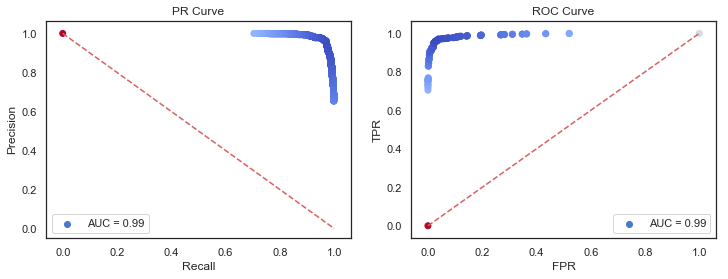

In [36]:
plot_curves(y_valid_bc, y_proba_bc)

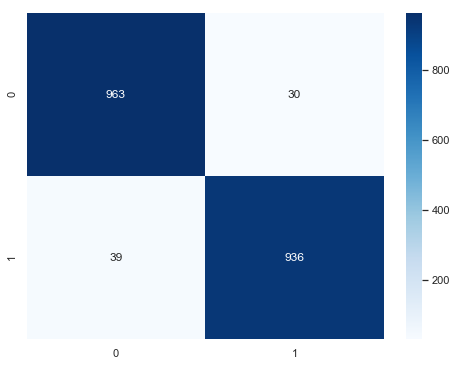

In [37]:
plot_confusion_matrix(y_valid_bc, y_proba_bc > .5)

In [38]:
print(classification_report(y_valid_bc, y_proba_bc > .5))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       993
         1.0       0.97      0.96      0.96       975

   micro avg       0.96      0.96      0.96      1968
   macro avg       0.97      0.96      0.96      1968
weighted avg       0.96      0.96      0.96      1968



### Autoencoder

In [39]:
# The autoencoder will try to learn only one class and automatically distinuish the other class

train_auto, valid_auto = train_test_split(non_fraud, test_size=0.1)
# Reserve positive samples for validation
valid_auto = valid_auto.append(fraud).reset_index(drop=True)
valid_classes = valid_auto.Class.values

train_auto = train_auto.drop('Class', axis=1).values
valid_auto = valid_auto.drop('Class', axis=1).values

train_auto.shape, valid_auto.shape

((255883, 30), (28924, 30))

In [40]:
# Rescale the values to be in range [0, 1] to compare with sigmoid
from sklearn.preprocessing import MinMaxScaler

train_auto = torch.FloatTensor(StandardScaler().fit_transform(train_auto))
valid_auto = torch.FloatTensor(StandardScaler().fit_transform(valid_auto))

train_auto.min(), train_auto.max()

(tensor(-84.0906), tensor(102.7499))

In [93]:
from torch.utils.data import TensorDataset, DataLoader

train_auto_ds = TensorDataset(train_auto, train_auto)
valid_auto_ds = TensorDataset(valid_auto, valid_auto)

In [42]:
from fastai.basic_data import DataBunch

data_auto = DataBunch.create(train_auto_ds, valid_auto_ds, bs=256)

next(iter(data_auto.train_dl))[0].shape, next(iter(data_auto.valid_dl))[0].shape

(torch.Size([256, 30]), torch.Size([256, 30]))

In [50]:
# We use autoencoder to iterate through (almost) the whole dataset and learn the distribution of non-fraud
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, in_size, h_size, z_size):
        super(Autoencoder, self).__init__()
        
        self.fc1 = nn.Linear(in_size, h_size)
        self.fc2 = nn.Linear(h_size, z_size)
        self.fc3 = nn.Linear(z_size, h_size)
        self.fc4 = nn.Linear(h_size, in_size)
        
    def encode(self, x):
        x = torch.relu(self.fc1(x))
        return torch.relu(self.fc2(x))
    
    def decode(self, x):
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)
    
# The more units the better model separates fraud from non-fraud in the latent space
autoencoder = Autoencoder(train_auto.shape[1], 100, 50)
autoencoder

Autoencoder(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=30, bias=True)
)

In [51]:
from fastai.train import Learner

learn_auto = Learner(data=data_auto, model=autoencoder, loss_func=nn.MSELoss())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


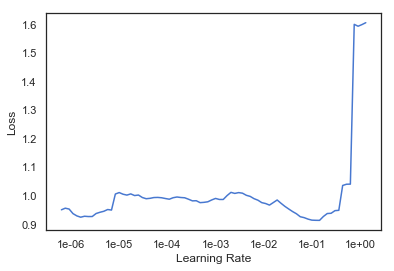

In [52]:
learn_auto.lr_find()
learn_auto.recorder.plot()

In [53]:
learn_auto.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss
1,0.112677,0.131508
2,0.011673,0.051477
3,0.000618,0.012373


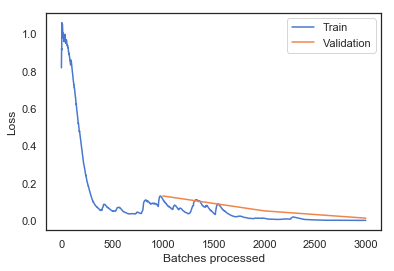

In [54]:
learn_auto.recorder.plot_losses()

In [55]:
learn_auto.save('autoencoder');

In [56]:
# Now let's try to predict fraud by using the reconstruction error
from fastai.basic_data import DatasetType

y_pred, y_true = learn_auto.get_preds(DatasetType.Valid)

In [57]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.cpu().numpy()

In [58]:
mse = np.mean(np.power(y_pred - y_true, 2), axis=1)
mse_df = pd.DataFrame({'mse': mse, 'Class': valid_classes})
mse_df.groupby(by='Class')['mse'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,28432.0,0.003935,0.017227,0.000055,0.001513,0.002416,0.003848,1.178044
1,492.0,0.500012,0.799085,0.000226,0.083242,0.239037,0.494846,5.567285


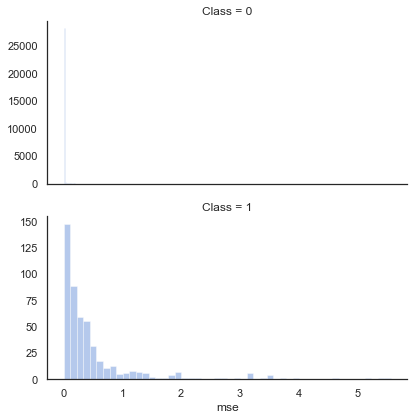

In [59]:
g = sns.FacetGrid(mse_df, sharey=False, height=3, aspect=2, row="Class")
g = g.map(sns.distplot, 'mse', kde=False, bins=50);

In [60]:
# Find best MSE threshold after which we consider predictions as one
from sklearn.metrics import precision_score, fbeta_score

def find_best_mse_threshold(mse_df):
    mse_threshold = 0
    max_score = 0
    for v in np.linspace(mse_df.mse.min(), mse_df.mse.max(), 100):
        bound_pred = (mse_df.mse > v).astype(int).values
        score = fbeta_score(mse_df.Class.values, bound_pred, 2.)
        if score > max_score:
            max_score = score
            mse_threshold = v
    return mse_threshold

mse_threshold = find_best_mse_threshold(mse_df)
mse_threshold

/Users/olegpolakow/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0562891798562663

In [61]:
y_pred = (mse_df.mse > mse_threshold).astype(int).values

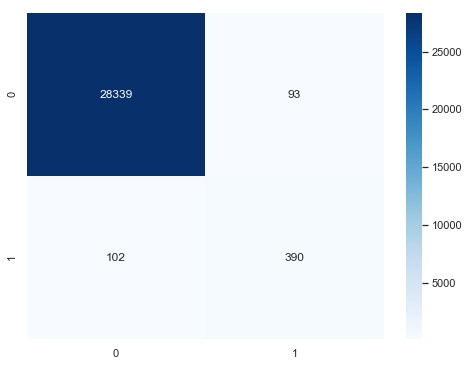

In [62]:
plot_confusion_matrix(mse_df.Class.values, y_pred)

In [63]:
# Obtain the latent representation
from fastai.callbacks import hooks

def get_z():
    z = []
    with hooks.hook_output(learn_auto.model.fc2) as hook:
        for batch, _ in learn_auto.data.valid_dl:
            m = learn_auto.model.eval()
            preds = m(batch)
            z.append(hook.stored.detach().cpu().numpy())
    return np.vstack(z)

z = get_z()

In [64]:
fraud_idxs = np.where(np.array(valid_classes) == 1)[0]
non_fraud_idxs = np.random.choice(np.where(valid_classes == 0)[0], len(fraud_idxs))
rand_idxs = list(fraud_idxs) + list(non_fraud_idxs)

len(fraud_idxs), len(non_fraud_idxs), len(rand_idxs)

(492, 492, 984)

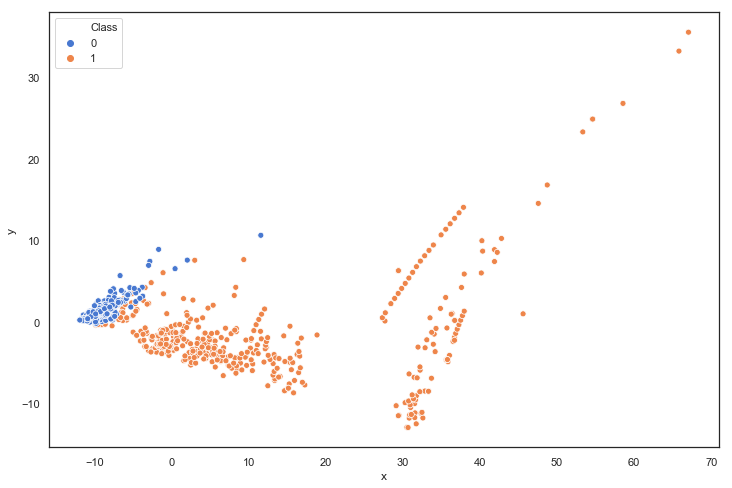

In [65]:
# Whether the model learned to distinguish between fraud and non-fraud
plot_pca(z[rand_idxs], valid_classes[rand_idxs])

### Autoencoder + binary classifier

In [66]:
learn_auto.load('autoencoder');

In [67]:
X_train_abc = torch.FloatTensor(StandardScaler().fit_transform(X_train))
X_valid_abc = torch.FloatTensor(StandardScaler().fit_transform(X_valid))
y_train_abc = torch.LongTensor(np.expand_dims(y_train, 1))
y_valid_abc = torch.LongTensor(np.expand_dims(y_valid, 1))

X_train_abc.shape, X_valid_abc.shape, y_train_abc.shape, y_valid_abc.shape

(torch.Size([2952, 30]),
 torch.Size([1968, 30]),
 torch.Size([2952, 1]),
 torch.Size([1968, 1]))

In [68]:
train_abc_ds = TensorDataset(X_train_abc, y_train_abc)
valid_abc_ds = TensorDataset(X_valid_abc, y_valid_abc)

In [69]:
bs = 64
data_abc = DataBunch.create(train_abc_ds, valid_abc_ds, bs=bs)

next(iter(data_abc.train_dl))[0].shape, next(iter(data_abc.valid_dl))[0].shape

(torch.Size([64, 30]), torch.Size([64, 30]))

In [70]:
# Use encoder as a frozen base and binary classifier as a head

class ABCModel(nn.Module):
    def __init__(self, autoencoder, z_size, h_size):
        super(ABCModel, self).__init__()
        self.autoencoder = autoencoder
        self.fc3 = nn.Linear(z_size, h_size)
        self.fc4 = nn.Linear(h_size, 1)

    def forward(self, x):
        x = self.autoencoder.encode(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)
    
model_abc = ABCModel(learn_auto.model, 50, 100)
model_abc

ABCModel(
  (autoencoder): Autoencoder(
    (fc1): Linear(in_features=30, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=30, bias=True)
  )
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=1, bias=True)
)

In [71]:
from fastai.layers import BCEWithLogitsFlat

learn_abc = Learner(data=data_abc, model=model_abc, loss_func=BCEWithLogitsFlat(pos_weight=pos_weight))

In [72]:
# Freeze encoder
from fastai.torch_core import requires_grad

requires_grad(learn_abc.model.autoencoder, False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


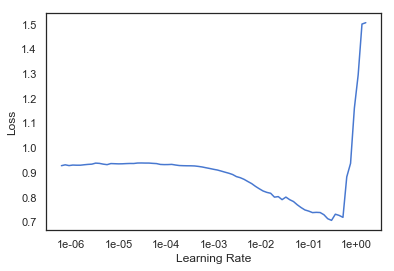

In [73]:
learn_abc.lr_find()
learn_abc.recorder.plot()

In [74]:
learn_abc.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,0.670978,0.462341
2,0.412867,0.327172
3,0.302720,0.236397
4,0.273582,0.265884
5,0.239525,0.224332
6,0.226805,0.232132
7,0.217267,0.254054
8,0.203228,0.212986
9,0.195640,0.215861
10,0.187756,0.212328


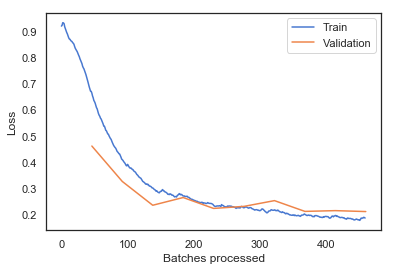

In [75]:
learn_abc.recorder.plot_losses()

In [76]:
learn_abc.save('autoencoder_bc_1')

In [77]:
requires_grad(learn_abc.model.autoencoder, True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


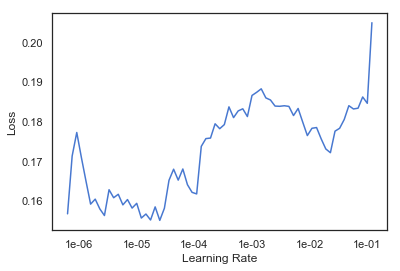

In [78]:
learn_abc.lr_find()
learn_abc.recorder.plot()

In [79]:
learn_abc.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss
1,0.176375,0.212327
2,0.178084,0.212292
3,0.176836,0.212237
4,0.178665,0.212145
5,0.173644,0.212181


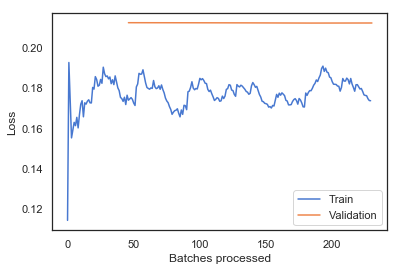

In [80]:
learn_abc.recorder.plot_losses()

In [81]:
learn_abc.save('autoencoder_bc_2')

In [122]:
y_proba_abc, _ = learn_abc.get_preds(DatasetType.Valid)

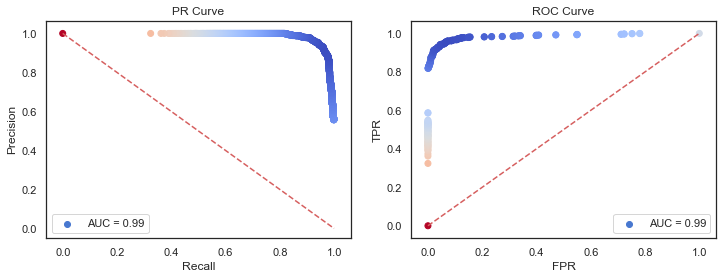

In [123]:
plot_curves(y_valid_abc, y_proba_abc)

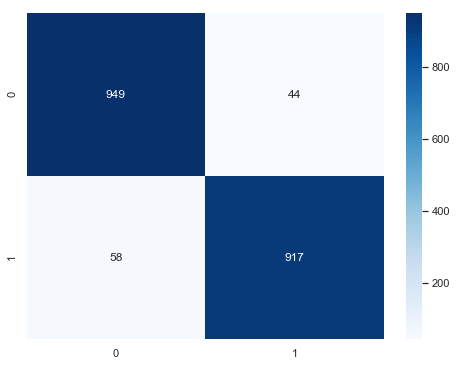

In [124]:
plot_confusion_matrix(y_valid_abc, y_proba_abc > .5)

In [125]:
print(classification_report(y_valid_abc, y_proba_abc > .5))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       993
           1       0.95      0.94      0.95       975

   micro avg       0.95      0.95      0.95      1968
   macro avg       0.95      0.95      0.95      1968
weighted avg       0.95      0.95      0.95      1968



### Compare results

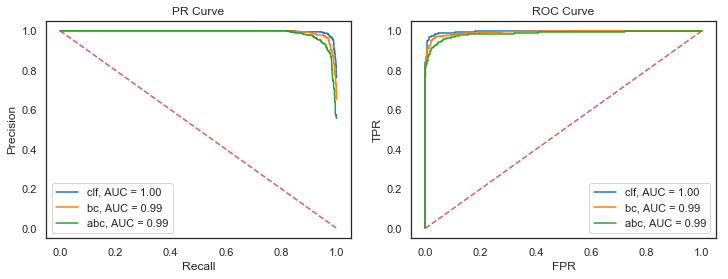

In [129]:
def compare_curves(y_true, y_probas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot([0, 1], [1, 0], 'r--')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')
    
    ax2.plot([0, 1], [0, 1], 'r--')
    ax2.set_xlabel('FPR')
    ax2.set_ylabel('TPR')
    ax2.set_title('ROC Curve')
    
    colors = [plt.cm.tab10(i) for i in range(len(y_probas))]
    for i, (name, y_proba) in enumerate(y_probas.items()):
        p, r, _ = precision_recall_curve(y_true, y_proba)
        pr_auc = average_precision_score(y_true, y_proba)
        ax1.plot(r, p, label='%s, AUC = %0.2f'% (name, pr_auc), c=colors[i])

        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = roc_auc_score(y_true, y_proba)
        ax2.plot(fpr, tpr, label='%s, AUC = %0.2f'% (name, roc_auc), c=colors[i])
    
    ax1.legend()
    ax2.legend()
    
    plt.show()
    
compare_curves(y_valid, {'clf': y_proba_clf, 'bc': y_proba_bc, 'abc': y_proba_abc})